## Human Protein Multi Label Image Classification 

 [Zero to GANs - Human Protein Classification](https://www.kaggle.com/c/jovian-pytorch-z2g)
 ### Acknowledgement
 
 - The basic of the notebook is taken from the starter notebook [Simple CNN Starter](https://www.kaggle.com/aakashns/simple-cnn-starter)
 - The efficient network part is taken from [Melanoma Competiton: Aug + ResNet/EffNet (LB 0.91)](https://www.kaggle.com/andradaolteanu/melanoma-competiton-aug-resnet-effnet-lb-0-91)
 - Early stopping and model checkpoint are taken from [Protein Classification Basic](https://www.kaggle.com/nachiket273/protein-classification-one-cycle), this kernel saved me a lot of training time. 
 
 Thanks to [Andrada](https://www.kaggle.com/andradaolteanu), [nachiket273](https://www.kaggle.com/nachiket273) and [Aakash](https://www.kaggle.com/aakashns) for sharing your work!

In [1]:
!pip install -q efficientnet_pytorch

In [2]:
import os
import torch
import random
import pandas as pd
import numpy as np
import cv2

from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
import torchvision.transforms.functional as TF

%matplotlib inline

## Exploring the Data

When you create a notebook with the "Notebooks" tab of a Kaggle competition, the data is automatically included in the `../input` folder. You can explore the files in the sidebar. Let us create some constants acess the data directories and CSV files.

In [3]:
DATA_DIR = '../input/zerotogan/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV = '../input/zerotogan/submission.csv'   # Contains dummy labels for test image

The `train.csv` file contains image IDs and labels for training data. Note that this is a multi-label classification problem. Each image can have more than one type of protein.

In [4]:
!head "{TRAIN_CSV}"

Image,Label
19567,9
29993,6 4
17186,1 4
29600,6 2
701,3 4
26562,9
1080,4
27886,4
30721,6


Similarly, `submission.csv` contains image IDs for test data. However, since the goal of this competition is to make predictions for the test set, the `submission.csv` files contains **dummy labels**, which you need to replace with your predictions and sumbit to the competition on the "Submission" tab. In other words, we don't have the labels for the test set.

In [5]:
!head "{TEST_CSV}"

Image,Label
24117,0
15322,0
14546,0
8079,0
13192,0
25927,0
3372,0
21781,0
2847,0


The image files are named `<image-id>.png` and can be found in the respective `train` and `test` folders.

In [6]:
!ls "{TRAIN_DIR}" | head

0.png
1.png
10000.png
10001.png
10005.png
10008.png
10009.png
10012.png
10013.png
10014.png
ls: write error: Broken pipe


Let's load the `train.csv` file into a Pandas dataframe

In [7]:
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


Let's also put the textual labels in a dictionary for later use.

In [8]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

To create a tensor from the labels, we will encode the labels as vectors of 1s & 0s. For example, if the labels are `'2 4 5'`, the correspoding vector for it would be `[0, 0, 1, 0, 1, 1, 0, 0, 0, 0]`. Let's define helper funtions to encode labels into tensors and vice versa.

In [9]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)


In [10]:
encode_label('2 4 5')

tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 0.])

In [11]:
decode_target(torch.tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0.]))

'2 4 5'

In [12]:
decode_target(torch.tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0.]), text_labels=True)

'Nucleoli(2) Nucleoplasm(4) Nucleoli fibrillar center(5)'

## Creating Datasets & Data Loaders

We can now create a custom dataset by extending the `Dataset` class from PyTorch. We need to define the `__len__` and `__getitem__` methods to create a dataset. We'll also provide the option of adding transforms into the constructor.

In [13]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
#         self.df = pd.read_csv(csv_file) 
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [14]:
# --- Read in Data ---

val_pct = 0.1
val_size = int(val_pct * len(train_df))
train_size = len(train_df) - val_size

train_data = train_df.iloc[:train_size].reset_index(drop=True)
valid_data = train_df.iloc[-val_size:].reset_index(drop=True)
train_size, val_size

(17313, 1923)

Transforms can be chained using `transforms.Compose`. For instance, you may add `transforms.Resize(128)` before `transforms.ToTensor()` to resize images to size 128x128 before converting them into tensors. See the full list of transforms here: https://pytorch.org/docs/master/torchvision/transforms.html

In [15]:
train_transform = transforms.Compose([  
#     transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(saturation=0.5,contrast=0.2),
    transforms.RandomRotation(45),

    transforms.ToTensor()
    ])

test_transform = transforms.Compose([
#     transforms.Resize(224),

    transforms.ToTensor()

    ])

train_ds = HumanProteinDataset(train_data, TRAIN_DIR, transform=train_transform)
val_ds = HumanProteinDataset(valid_data, TRAIN_DIR, transform=test_transform)

Let's check how many samples the dataset contains

Let's take a look at a sample image from the dataset. We'll define a function `show_sample` to help us. We will also include the option to invert the image before showing it, because the original images are quite dark.

In [16]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))
    

Here's a sample image without the colors inverted.

Labels: Nuclear speckles(9)


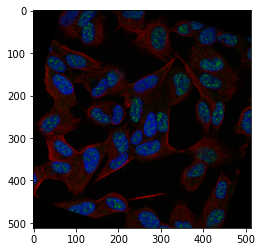

In [18]:
show_sample(*train_ds[0], invert=False)

Here's the same image viewed with the colors inverted

Labels: Nuclear speckles(9)


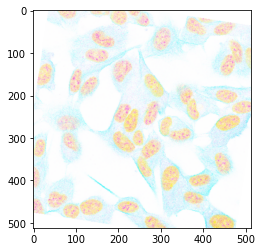

In [19]:
show_sample(*train_ds[0])

### Training & Validation sets

As a good practice, we should split the data into training and validation datasets. Let's fix a seed for PyTorch (to ensure we always get the same validation set), and create the datasets using `random_split`.

In [20]:
torch.manual_seed(10)

I'm using a validation percentage of 10%, but you can use a smaller or larger percentage. One good strategy is to determine a good set of hyperparameters, and then retrain on a smaller validation set for your final submission.

In [21]:
# train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(17313, 1923)

In [22]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

## Data Loaders

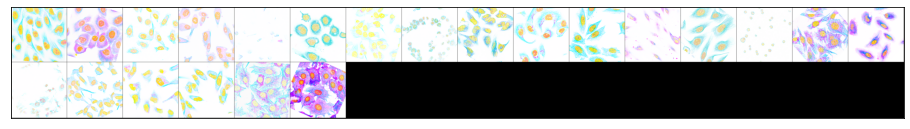

In [23]:
batch_size = 22

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

show_batch(train_dl)

## Model

In [24]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [25]:
ALPHA = 0.25
GAMMA = 2
FOCAL_LOSS = False

class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)      
        
        loss = F.binary_cross_entropy(out, targets)
        bce_exp = torch.exp(-loss)
        focal_loss = ALPHA * (1-bce_exp)**GAMMA * loss
        if FOCAL_LOSS: loss = focal_loss
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images) 
        # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        bce_exp = torch.exp(-loss)
        focal_loss = ALPHA * (1-bce_exp)**GAMMA * loss
        
        score = F_score(out, targets)
        if FOCAL_LOSS: loss = focal_loss
            
        return {'val_loss': loss.detach(), 'val_score': score.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [26]:
class EfficientNetwork(MultilabelImageClassificationBase):
    def __init__(self, b4=False, b2=False):
        super().__init__()
        self.b4, self.b2 = b4, b2
        
        # Define Feature part
        if b4:
            self.features = EfficientNet.from_pretrained('efficientnet-b4')
        elif b2:
            self.features = EfficientNet.from_pretrained('efficientnet-b2')
        else:
            self.features = EfficientNet.from_pretrained('efficientnet-b1')
        
        # Define Classification part
        if b4:
            self.classification = nn.Linear(1792, 10)
        elif b2:
            self.classification = nn.Linear(1408, 10)
        else:
            self.classification = nn.Linear(1280, 10)
        
        
    def forward(self, image, prints=False):
        if prints: print('Input Image shape:', image.shape)
        
        image = self.features.extract_features(image)
        if prints: print('Features Image shape:', image.shape)
            
        if self.b4:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1792)
        elif self.b2:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        else:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1280)
        if prints: print('Image Reshaped shape:', image.shape)
        
        out = self.classification(image)
        if prints: print('Out shape:', out.shape)
        
        return torch.sigmoid(out)
    
    

In [27]:
  class Resnet(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [29]:
model = EfficientNetwork(b4=False, b2=False)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/checkpoints/efficientnet-b1-f1951068.pth



Loaded pretrained weights for efficientnet-b1


### Count number of parameters

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

7806994

In [31]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
device = get_default_device()
device

device(type='cuda')

In [33]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [34]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([22, 3, 512, 512])
out.shape: torch.Size([22, 10])
out[0]: tensor([0.4796, 0.5101, 0.4626, 0.4808, 0.4733, 0.5256, 0.4992, 0.4852, 0.5228,
        0.4666], device='cuda:0', grad_fn=<SelectBackward>)


If your kernel runs out of memory here, you might need to reduce your batch size.

## Training the model

In [35]:
from tqdm.notebook import tqdm

In [36]:
es_patience = 5
num_epochs = 26

lr_patience = 2
lr_factor = 0.2
lr = 0.0001
max_lr = 0.01

weight_decay = 0.01
amsgrad=True

opt_func = torch.optim.AdamW

In [37]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, max_lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    lrs = []
    valid_loss_min = np.Inf
    model_file_name = 'best_model.pth'
    epochs_no_improve =  0
    
    optimizer = opt_func(model.parameters(), lr=lr, amsgrad=amsgrad, weight_decay=weight_decay)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=epochs)
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=2)

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            lrs.append(get_lr(optimizer))
            
        # Validation phase   
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        valid_loss = result['val_loss']

        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > es_patience:
                model.epoch_end(epoch, result)
                history.append(result)
                return history  
            
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [38]:
model = to_device(model, device)

Loaded pretrained weights for efficientnet-b1


In [39]:
evaluate(model, val_dl)

{'val_loss': 0.698772132396698, 'val_score': 0.22521159052848816}

In [40]:
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.2594, val_loss: 0.2079, val_score: 0.7310



Epoch [1], train_loss: 0.2239, val_loss: 0.2793, val_score: 0.6288



Epoch [2], train_loss: 0.2247, val_loss: 0.2932, val_score: 0.5496



Epoch [3], train_loss: 0.2263, val_loss: 0.3124, val_score: 0.5281



Epoch [4], train_loss: 0.2286, val_loss: 0.3186, val_score: 0.4851



Epoch [5], train_loss: 0.2279, val_loss: 0.2719, val_score: 0.6927



Epoch [6], train_loss: 0.2243, val_loss: 0.3926, val_score: 0.5994



Epoch [7], train_loss: 0.2237, val_loss: 0.2354, val_score: 0.6934



Epoch [8], train_loss: 0.2210, val_loss: 0.2290, val_score: 0.7150



Epoch [9], train_loss: 0.2172, val_loss: 0.3084, val_score: 0.6394



Epoch [10], train_loss: 0.2123, val_loss: 0.3109, val_score: 0.5687



Epoch [11], train_loss: 0.2107, val_loss: 0.2281, val_score: 0.7130



Epoch [12], train_loss: 0.2082, val_loss: 0.2507, val_score: 0.6573



Epoch [13], train_loss: 0.2012, val_loss: 0.3042, val_score: 0.5515



Epoch [14], train_loss: 0.1983, val_loss: 0.2149, val_score: 0.6925



Epoch [15], train_loss: 0.1937, val_loss: 0.2012, val_score: 0.7474



Epoch [16], train_loss: 0.1915, val_loss: 0.1835, val_score: 0.7648



Epoch [17], train_loss: 0.1881, val_loss: 0.1891, val_score: 0.7543



Epoch [18], train_loss: 0.1817, val_loss: 0.1747, val_score: 0.7774



Epoch [19], train_loss: 0.1789, val_loss: 0.1742, val_score: 0.7771



Epoch [20], train_loss: 0.1737, val_loss: 0.1647, val_score: 0.7989



Epoch [21], train_loss: 0.1703, val_loss: 0.1638, val_score: 0.7888



Epoch [22], train_loss: 0.1672, val_loss: 0.1599, val_score: 0.7901



Epoch [23], train_loss: 0.1650, val_loss: 0.1577, val_score: 0.8013



Epoch [24], train_loss: 0.1622, val_loss: 0.1578, val_score: 0.8002



Epoch [25], train_loss: 0.1618, val_loss: 0.1574, val_score: 0.8025


## Making predictions & submission
To start with, let's create a helper function to make a prediction on a single image.

In [57]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

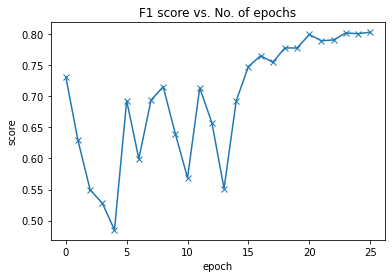

In [58]:
plot_scores(history)

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

Next, let's create a test dataset using the `submission.csv` file. Note that the file contains dummy labels (always `'0'`). We'll use the same transforms we used for the training set.

In [83]:
#TODO train_transform and test_transform
test_data = pd.read_csv(TEST_CSV)
test_dataset = HumanProteinDataset(test_data, TEST_DIR, transform=train_transform)

In [84]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 512, 512])

Let's try predicting the labels for some sample images

Prediction:  tensor([5.0448e-04, 3.6205e-02, 3.0802e-01, 2.3206e-03, 9.6595e-01, 3.6863e-03,
        8.8054e-01, 9.3888e-03, 2.6870e-03, 2.1124e-03], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Nucleoplasm(4) Cytosol(6)


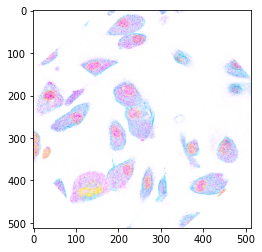

In [85]:
predict_single(test_dataset[100][0])

Prediction:  tensor([6.9876e-01, 2.2475e-03, 1.9630e-03, 6.3069e-01, 3.3552e-02, 5.5684e-04,
        1.8079e-02, 1.5779e-03, 1.0911e-02, 3.3886e-05], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Mitochondria(0) Golgi apparatus(3)


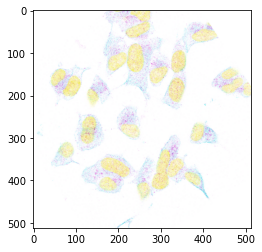

In [86]:
predict_single(test_dataset[74][0])

## Creating a submission file

In [87]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, 40, num_workers=2, pin_memory=True), device)

In [88]:

# Get probability instead of classes
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)      
    return  [x.numpy() for x in batch_probs]
#     return [decode_target(x) for x in batch_probs]

In [ ]:
test_preds = predict_dl(test_dl, model)

Let us know create a submission file with these predictions

In [79]:
len(test_preds)

8243

In [80]:
len(submission_df)

8243

In [81]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.head()

,Image,Label
0,24117,"[0.00157015, 0.1334155, 4.534283e-05, 0.025351..."
1,15322,"[0.0090379175, 0.26640904, 0.011564388, 0.0158..."
2,14546,"[0.0026181268, 0.010622817, 0.0071916427, 0.00..."
3,8079,"[0.20403714, 0.0014362877, 0.0054815304, 0.416..."
4,13192,"[0.0209371, 0.029924503, 0.015563068, 0.956274..."


We can now save it batck to CSV, and download the file from the sidebar (check the output folder)

In [82]:
sub_fname = 'efficientb1_submission_0.8025_prob_train_tf.csv'
submission_df.to_csv(sub_fname, index=False)

You can now upload this submission file here: https://www.kaggle.com/c/jovian-pytorch-z2g/submit